In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
cwd = os.getcwd()
maindir = os.path.dirname(cwd)

filepath = os.path.join(maindir,'data/external')
#os.listdir(filepath)

In [3]:
df = pd.read_csv(os.path.join(filepath,'training_v2.csv'))
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [5]:
# Look at our target variable: hospital_death
df.groupby('hospital_death').hospital_death.count()

hospital_death
0    83798
1     7915
Name: hospital_death, dtype: int64

In [6]:
# Change this to text to use with Seaborn
lgd = dict({0:'Survived',1:'Died'})
df['Survived'] = df['hospital_death'].map(lgd)

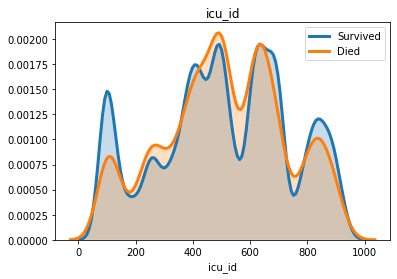

In [7]:
# What about getting summary statistics?

# Numerical can use Pearson covariance coefficient to get first approximation. 
# (Pearson assumes linarity and continuous ...we have a binary output)
def getCov(x):
    cov = np.corrcoef(df['hospital_death'],df[x])
    return round(cov[0, 1],3)

def plotCatBar(x):
    """ Counts and plots categorical data sorted by hospital death"""
    df.groupby(x).hospital_death.value_counts()
    tbl = pd.crosstab(df[x], df.hospital_death, normalize='index')
    tbl.plot(kind='bar')
    plt.title(x)
    plt.show()
    
def plotKDE(x):
    """ Plots numerical data sorted by hospital death"""
    filtered_df = df[df['hospital_death']==0]
    _ = sns.distplot(filtered_df[x], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = 'Survived')

    filtered_df = df[df['hospital_death']==1]
    _ = sns.distplot(filtered_df[x], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = 'Died')
    plt.title(x)
    plt.show()
    
getCov('age')
plotKDE('icu_id')

In [8]:
# Look through the data for number of unique values. 
vals = df.nunique()
vals[vals < 3]
vals[(vals > 2) & (vals < 10)]
vals[(vals > 10) & (vals < 200)]
vals[vals > 200].sort_values()

d1_temp_min                209
h1_hco3_max                214
d1_hco3_max                223
d1_sysbp_invasive_max      225
icu_id                     241
                         ...  
pre_icu_los_days          9757
urineoutput_apache       24772
bmi                      34888
patient_id               91713
encounter_id             91713
Length: 78, dtype: int64

####  Unique values at a df level aren't super helpful here as many patients will have their own values . Let's look at columns with null data. 

In [9]:
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent'])
pos = (nas['percent'] >= 0.2) & (nas['percent'] < 0.3)
nas[pos]

,percent
wbc_apache,0.240010
h1_temp_max,0.236957
h1_temp_min,0.236957
hospital_admit_source,0.233435
hematocrit_apache,0.216741
bun_apache,0.210025
creatinine_apache,0.205565
sodium_apache,0.202807


#### Look for columns that are mostly empty

>90%     : bilirubin, lactate, albumin
<br/> 80 - 90% : h1_pao2fio2ratio, arterial_ph, hco3, arterial pco2, wbc, arterial_po2, calcium, platelets,bun, creatinine, diasbp_invasive, sysbp_invasive, mbp, invasive, hematocrit
<br/> 70 - 80% : hemaglobin, sodium, potassium, ph_apache, pao2_apache, paco2_for_ph_apache, fio2_apache, paco2_apache, diasbp_invasive, sysbp_invasive, mbp_invasive, d1_pao2fio2ratio
<br/> ** Note ** all of the apache scores have the same missing values
<br/> 60 - 70% : arterial_ph, arterial_pco2, arterial_po2, bilirubin_apache, inr both h1 and d1
<br/> 50 - 60% : albumin_apache, bilirubin, glucose, albumin, urineoutput_apache
<br/> 30 - 50% : no columns
<br/> 20 - 30% : wbc_apache, temp, hosptial_admit_source, hematocrit_apache, bun_apache, creatinine_apache, sodium_apache
<br/> 10 - 20% : all d1 vitals: hco3, platelets, wbc, calcium, hemaglobin, hematocrit, glucose apache, bun, sodium, creatininte, potassium

####  Empty columns can be grouped

* Top missing data is from h1_vitals. Here 'h1' means it was taken during their first hour in the stay. 'd1' is during the first 24 hours. 
    - It could be intersting to look if the patients have both h1 and d1, which may mean two measurements. Check if they are the same. 
    - It could also be that some hospitals take vitals within the hour or that having an h1 score at all means a condition is more serious

* Invasive measures and lab blood gas are also typically missing. THis makes sense and is probably only required for certain conditions.



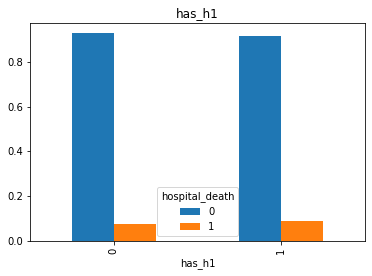

elective_surgery,0,1
has_h1,,
0,0.007218,0.001461
1,0.809046,0.182275


In [10]:
# Get columns with 'h1' and create identifier column
hour1 = df.columns[['h1' in i for i in df.columns]]
has_h1= (df[hour1].notna().sum(axis=1) > 0).astype(int)
df = df.assign(has_h1=has_h1.values)

plotCatBar('has_h1')

tbl = pd.crosstab(df['has_h1'],df['elective_surgery'], normalize =True)
tbl

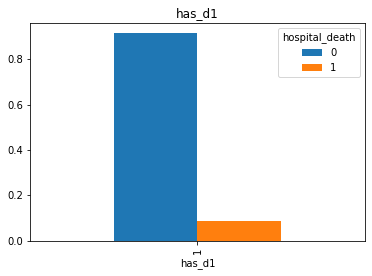

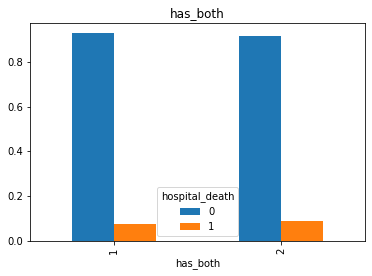

In [74]:
# Get columns with 'd1' and create identifier column
day1 = df.columns[['d1' in i for i in df.columns]]
has_d1= (df[day1].notna().sum(axis=1) >0 ).astype(int)
df = df.assign(has_d1=has_d1.values)

plotCatBar('has_d1')

df = df.assign(has_both=has_d1.values + has_h1.values)
plotCatBar('has_both')

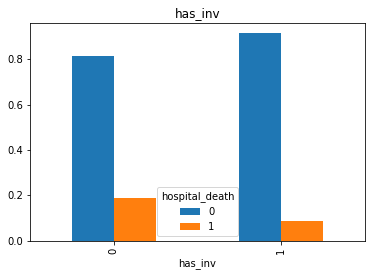

In [12]:
# Get columns with 'invasive' and create identifier column
inv = df.columns[['invasive' in i for i in df.columns]]
has_inv= (df[inv].notna().sum(axis=1) > 0).astype(int)
df = df.assign(has_inv=has_inv.values)

plotCatBar('has_inv')

In [13]:
# Use the categories from the provided dictionary to look at the data in groups
categories = pd.read_csv(os.path.join(filepath,'WiDS Datathon 2020 Dictionary.csv'))
print(categories['Category'].unique())

identifier = categories[categories['Category']=='identifier']['Variable Name'].tolist()
demographic = categories[categories['Category']=='demographic']['Variable Name'].tolist()

# Fix error in demographic. It includes 'icu_admit_type' which is not in the table
demographic.remove('icu_admit_type')

Acov = categories[categories['Category']=='APACHE covariate']['Variable Name'].tolist()
vitals = categories[categories['Category']=='vitals']['Variable Name'].tolist()

labs = categories[categories['Category']=='labs']['Variable Name'].tolist()
lab_bg = categories[categories['Category']=='lab blood gas']['Variable Name'].tolist()

Apredict = categories[categories['Category']=='APACHE prediction']['Variable Name'].tolist()
Acom = categories[categories['Category']=='APACHE comorbidity']['Variable Name'].tolist()

Agroup = categories[categories['Category']=='APACHE group']['Variable Name'].tolist()
GOSSIS = categories[categories['Category']=='GOSSIS example prediction']['Variable Name'].tolist()


['identifier' 'demographic' 'APACHE covariate' 'vitals' 'labs'
 'labs blood gas' 'APACHE prediction' 'APACHE comorbidity'
 'APACHE grouping' 'GOSSIS example prediction']


In [31]:
Acov


['albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache']

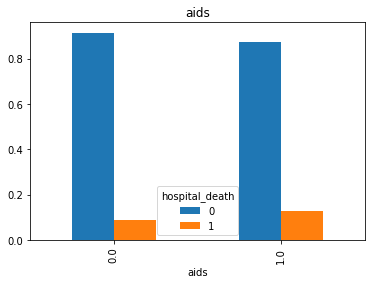

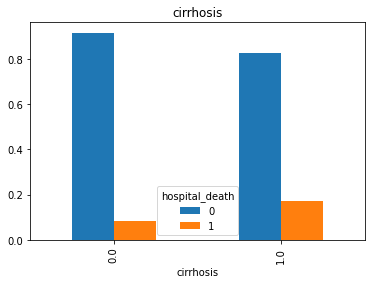

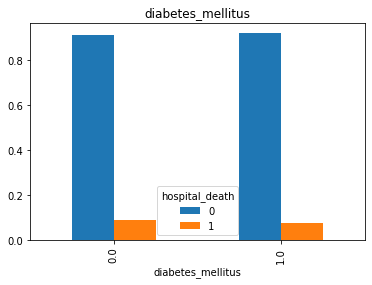

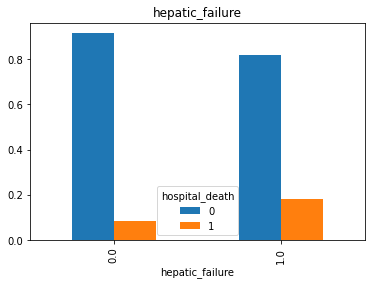

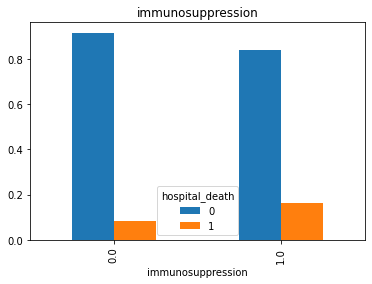

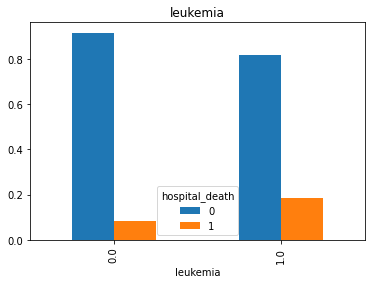

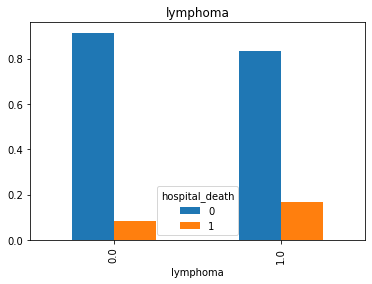

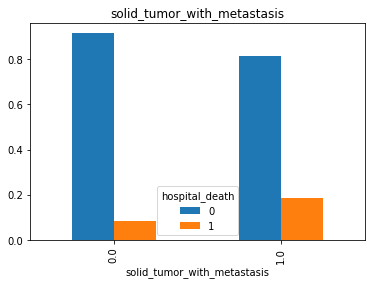

In [15]:
# Look at summary statistics for comorbidities
for i,col in enumerate(Acom):
    plotCatBar(str(col))

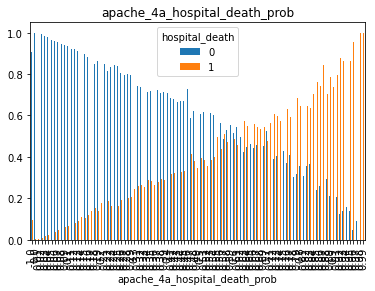

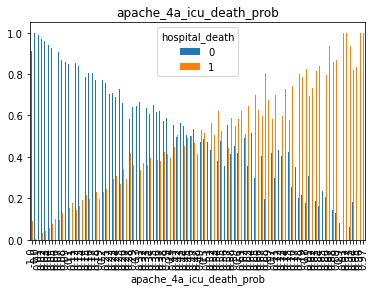

In [16]:
# Look at summary statistics for each predictions
for i,col in enumerate(Apredict):
    plotCatBar(str(col))

In [17]:
# Check outliers
test_df = df[demographic]
nas=pd.DataFrame(test_df.isnull().sum().sort_values(ascending=False)/len(test_df),columns = ['percent'])
pos = (nas['percent'] >= 0)
nas[pos]

,percent
hospital_admit_source,0.233435
age,0.046100
bmi,0.037388
weight,0.029658
ethnicity,0.015210
height,0.014545
icu_admit_source,0.001221
gender,0.000273
readmission_status,0.000000
pre_icu_los_days,0.000000


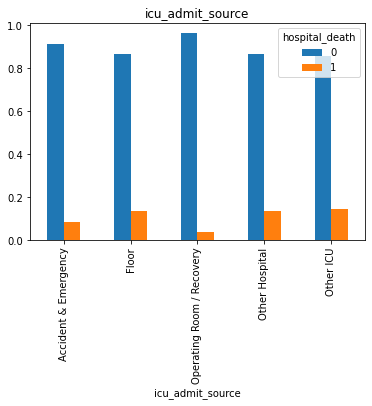

In [19]:
plotCatBar('icu_admit_source')

### Address Demographic NaN

* hospital_admit_source (23%) and icu_admit_source (0.1%)
    - icu_admit_score seems to hold better keyed data with the majority of missing hospital_admit_data in 1 of 3 buckets. 
* numeric: age, bmi, weight, height 
* categorical: ethnicity, gender

In [20]:
df['hospital_admit_source'].fillna('Empty',inplace=True)
check_combo = df['hospital_admit_source'] + '_' + df['icu_admit_source']
check_combo.value_counts(ascending=True)

Other_Operating Room / Recovery                  1
Other_Accident & Emergency                       1
Observation_Accident & Emergency                 1
ICU_Other Hospital                               1
Other ICU_Floor                                  2
                                             ...  
Direct Admit_Accident & Emergency             5749
Floor_Floor                                   7471
Operating Room_Operating Room / Recovery      9447
Empty_Accident & Emergency                   12677
Emergency Department_Accident & Emergency    35193
Length: 70, dtype: int64

In [21]:
df[df['hospital_admit_source'] == 'Empty']['icu_admit_source'].value_counts()

Accident & Emergency         12677
Floor                         4115
Operating Room / Recovery     3670
Other Hospital                 671
Other ICU                      165
Name: icu_admit_source, dtype: int64

#### Numeric: Age, BMI, Weight, Height

/Users/maureenkeenan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/maureenkeenan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


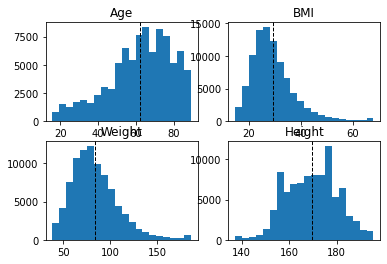

In [22]:
# Plot age, bmi, weight, height as histograms
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.hist(df['age'], bins= 20)
plt.axvline(df['age'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Age')

plt.subplot(2, 2, 2)
plt.hist(df['bmi'], bins= 20)
plt.axvline(df['bmi'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('BMI')

plt.subplot(2, 2, 3)
plt.hist(df['weight'], bins= 20)
plt.axvline(df['weight'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Weight')

plt.subplot(2, 2, 4)
plt.hist(df['height'], bins= 20)
plt.axvline(df['height'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Height')

plt.show()

# Error is from nan in data. Leave it for now. 

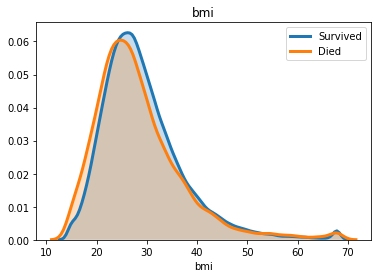

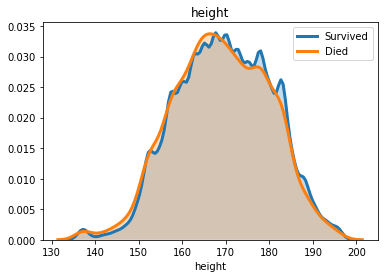

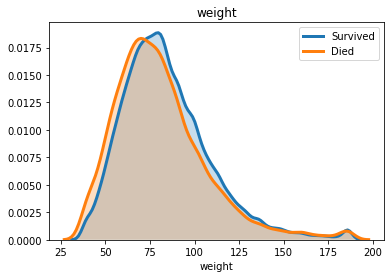

In [23]:
plotKDE('bmi')
plotKDE('height')
plotKDE('weight')

In [24]:
df['age'].agg([np.median,np.mean])

median    65.000000
mean      62.309516
Name: age, dtype: float64

#### Ethnicity (1.5% missing) and Gender (.02% missing)
* Replace ethnicity with most likely
    - Caucasian is by far the most represented ethnicity. But it is not the highest to pass. Look into this further.
* Drop rows missing gender

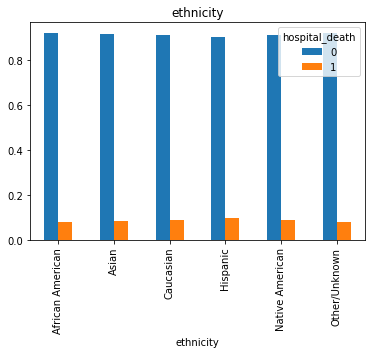

In [25]:
# This is probably where pivot_table and melting is useful. But easier for now to make a separate dataframe.
plotCatBar('ethnicity')

### Apache

* Apache 4
    * Apache 4 still has missing data in both 'apache_4a_icu_death_prob' and 'apache_4a_hospital_death_prob'
    * Apache 4 has >2000 cases of probability = -1. -1 does not necessarily mean survive or not. However! icu and hospital have different places they are -1. 
* Apache 3
    * Appears twice - bodysystem (category) and diagnosis (numeric)
* Apache 2
    * Appears twice - bodysystem (category) and diagnosis (numeric)  

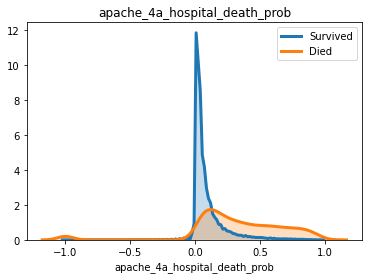

In [26]:
plotKDE('apache_4a_hospital_death_prob')

In [27]:
df[df['apache_4a_icu_death_prob'] == -1]['hospital_death'].count()

2230

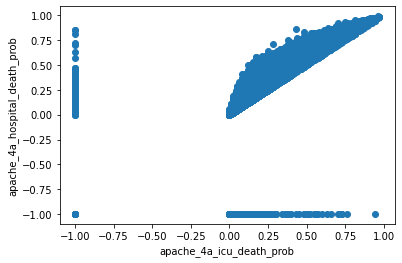

In [28]:
# Look at Apache
plt.scatter(df.apache_4a_icu_death_prob, df.apache_4a_hospital_death_prob)
plt.xlabel('apache_4a_icu_death_prob')
plt.ylabel('apache_4a_hospital_death_prob')
plt.show()

In [ ]:
# Make a new column...
df['apache4'] = apache_4

#...and drop the other ones
#df = df.drop(columns = ['apache_4a_hospital_death_prob','apache_4a_icu_death_prob'])

#### Check the distributions of the apache4.

* Our '-1' follows the same trend as the data. I can't set it to 0 because that would change the probability of surviving from 0.3 to 3%. Instead, setting it 9% (and then adding that data into the exisitn 9% data) doesn't change. 
* The mean is close (affected by the -1) and easier to do on the test set. Set 'NA' and '-1' to mean of Apache4. 

In [ ]:
# Well that didn't do much. Fixed  321 rows. 
print('Apache4 = -1', df[df['apache4'] == -1]['hospital_death'].agg([sum,len]))
print('Apache4 = 0', df[df['apache4'] == 0.09]['hospital_death'].agg([sum,len]))

In [ ]:
# Comparing data
print('Apache 4 = -1 died' , 168/1824*100)
print('Apache 4 = 0 died' , 85/979*100)
print('Apache 4 = 0 died' , (168+85)/(1824+979)*100)
print(df['apache4'].mean())

In [ ]:
# Set the mean and then change both -1 and NaN to the same value...
fillVal = df['apache4'].mean()
# First fillNA
df['apache4'] = df['apache4'].fillna(fillVal)
# Then update -1
df['apache4'] = df['apache4'].replace(-1, fillVal)
min(df['apache4'])

#### Apache 3 and 2
* Have both a Bodysystem (category) and diagnosis (numeric)

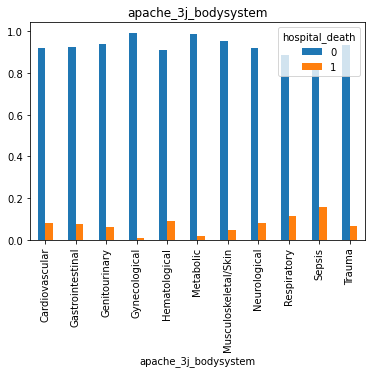

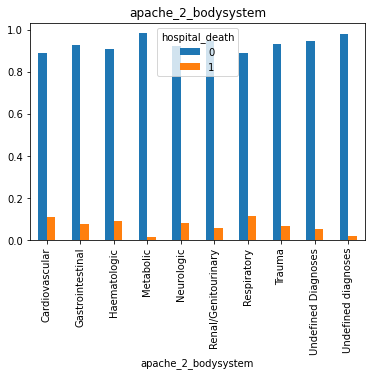

apache_2_bodysystem,Cardiovascular,Gastrointestinal,Haematologic,Metabolic,Neurologic,Renal/Genitourinary,Respiratory,Trauma,Undefined Diagnoses,Undefined diagnoses
apache_3j_bodysystem,,,,,,,,,,
Cardiovascular,27051,0,0,0,0,0,0,0,0,2948
Gastrointestinal,0,9026,0,0,0,0,0,0,0,0
Genitourinary,25,0,0,0,0,2147,0,0,0,0
Gynecological,0,0,0,0,0,313,0,0,0,0
Hematological,0,0,638,0,0,0,0,0,0,0
Metabolic,0,0,0,7650,0,0,0,0,0,0
Musculoskeletal/Skin,0,0,0,0,0,0,0,0,346,820
Neurological,0,0,0,0,11896,0,0,0,0,0
Respiratory,0,0,0,0,0,0,11609,0,0,0


In [32]:
plotCatBar('apache_3j_bodysystem')
plotCatBar('apache_2_bodysystem')

pd.crosstab(df.apache_3j_bodysystem,df.apache_2_bodysystem)

In [33]:
df['apache_3j_bodysystem'].value_counts(dropna=False)

Cardiovascular          29999
Neurological            11896
Sepsis                  11740
Respiratory             11609
Gastrointestinal         9026
Metabolic                7650
Trauma                   3842
Genitourinary            2172
NaN                      1662
Musculoskeletal/Skin     1166
Hematological             638
Gynecological             313
Name: apache_3j_bodysystem, dtype: int64

In [ ]:
df['apache_3j_diagnosis'].agg([np.mean,max, min])

In [ ]:
df['apache_2_bodysystem'].value_counts(dropna=False)

In [ ]:
df['apache_2_diagnosis'].agg([np.mean,max, min])

In [ ]:
plotKDE('apache_2_diagnosis')
plotKDE('apache_3j_diagnosis')

np.corrcoef(df.apache_2_diagnosis, df.apache_3j_diagnosis)[0,1]

In [ ]:
df[df['apache_2_diagnosis'].isna()]['apache_3j_bodysystem'].sum()

**Explore labs**

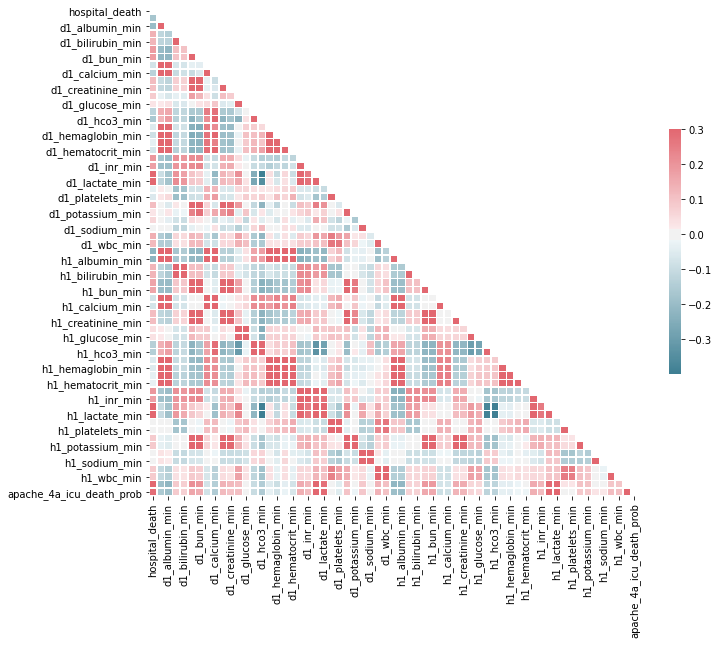

In [34]:
corr = df[['hospital_death'] + labs + Apredict].corr(method='pearson')
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [35]:
corr[abs(corr['hospital_death']) > .5].T.sort_values(by='hospital_death')

,hospital_death
h1_albumin_min,-0.225402
h1_albumin_max,-0.224928
d1_albumin_min,-0.200590
d1_albumin_max,-0.173460
d1_hco3_min,-0.163213
...,...
h1_lactate_max,0.340951
h1_lactate_min,0.344046
d1_lactate_max,0.399029
d1_lactate_min,0.403614


**lactate max and min and h1 and d1 has a relatively high correlation. These are also emtpy fields. Combine them..**

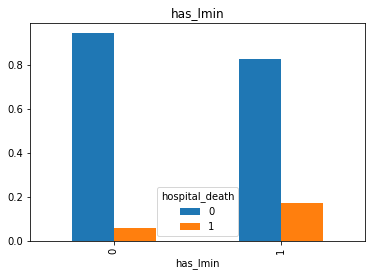

nan

In [49]:
# Get lactate_min columns
lmin = df.columns[['lactate_min' in i for i in df.columns]]
# Sort by NOTNA or ISNA
has_lmin = (df[lmin].notna().sum(axis=1)>0).astype(int)
df = df.assign(has_lmin=has_lmin.values)
df = df.assign(lactate_min = np.max(df[lmin],axis=1))
df['lactate_min'] = df['lactate_min'].fillna(1)
    
plotCatBar('has_lmin')

np.corrcoef(df.d1_lactate_min,df.hospital_death)[0,1]

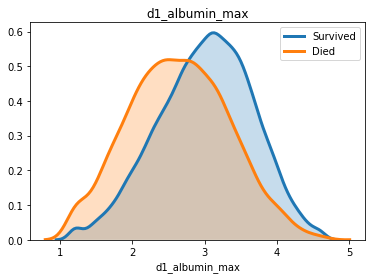

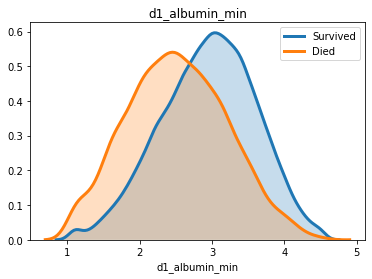

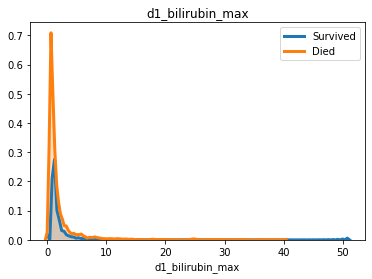

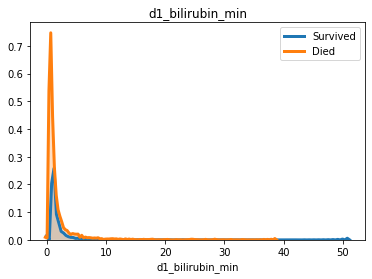

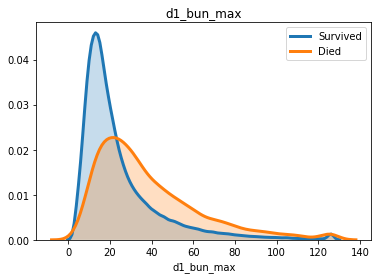

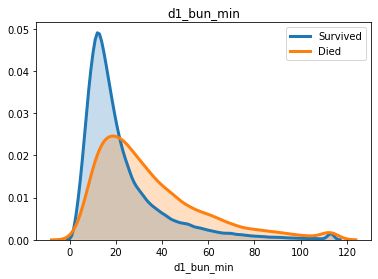

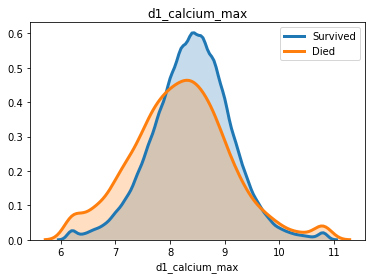

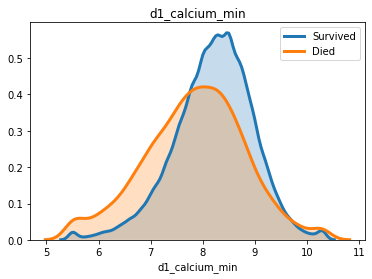

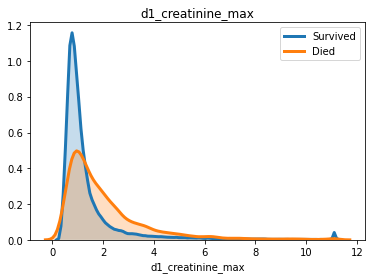

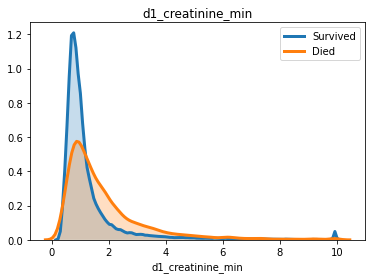

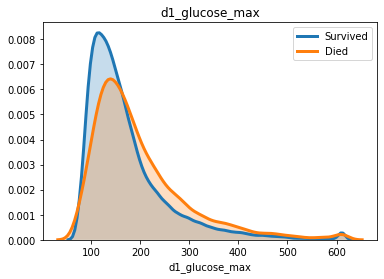

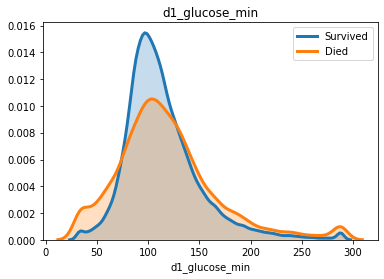

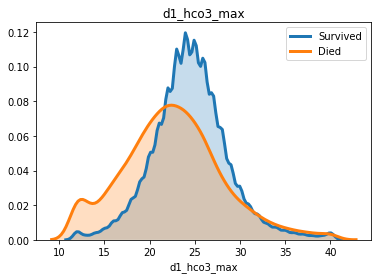

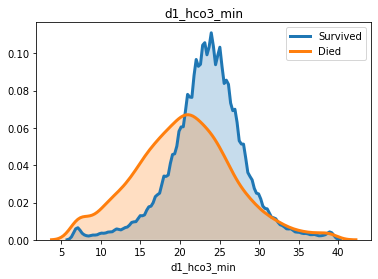

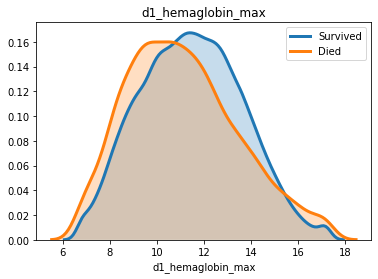

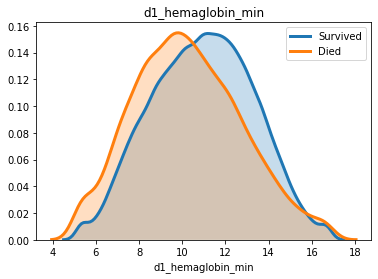

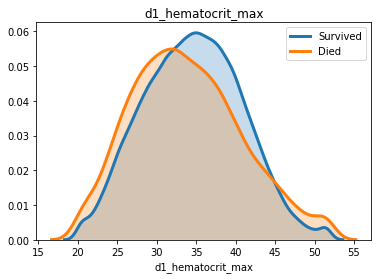

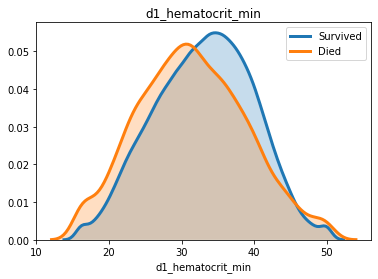

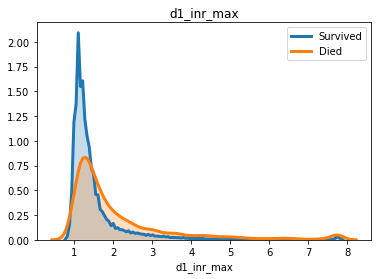

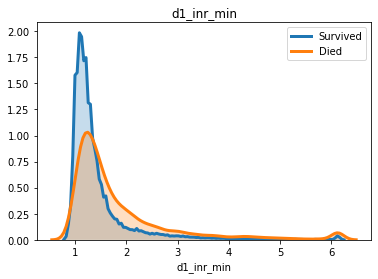

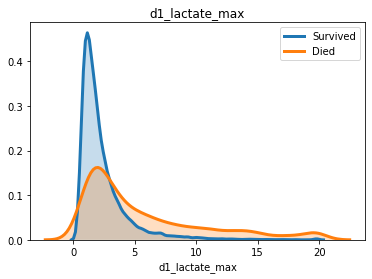

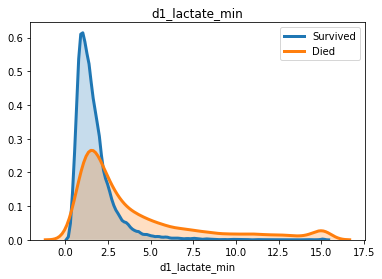

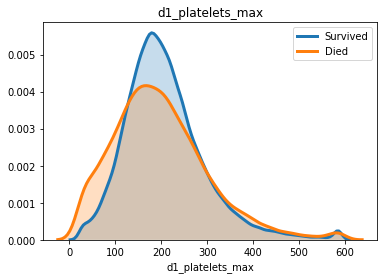

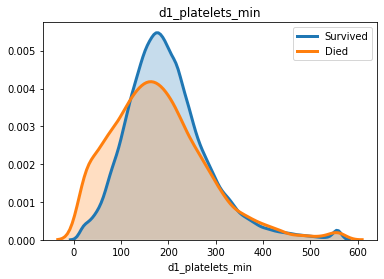

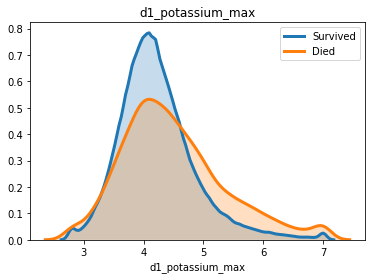

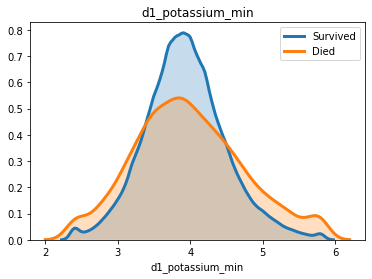

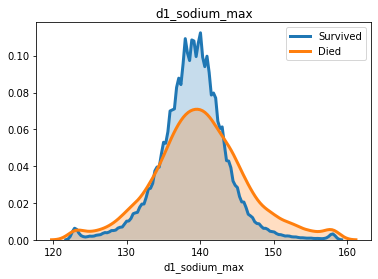

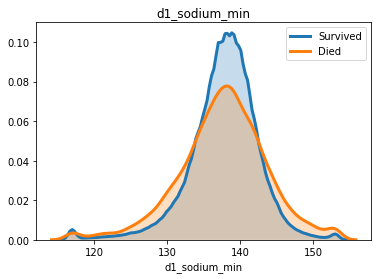

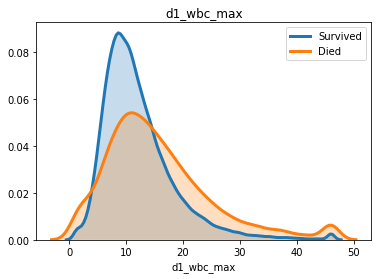

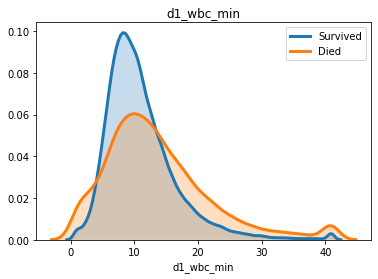

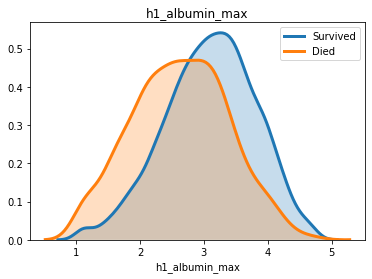

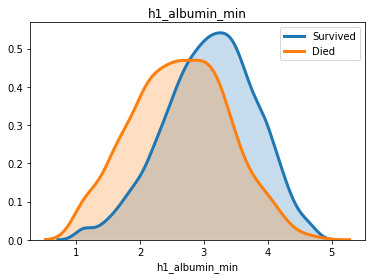

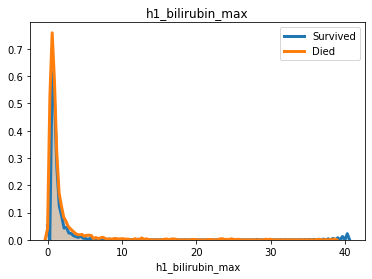

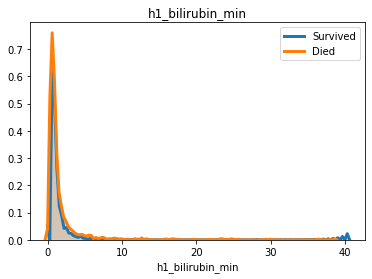

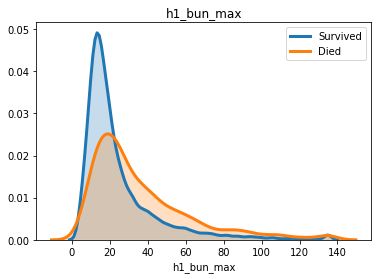

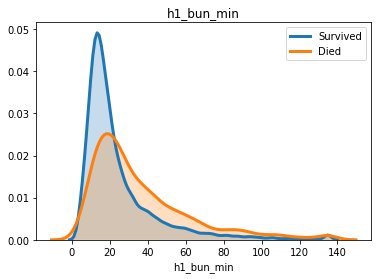

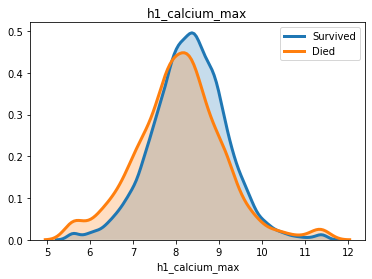

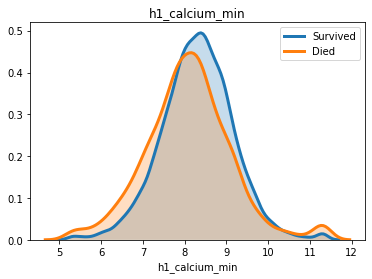

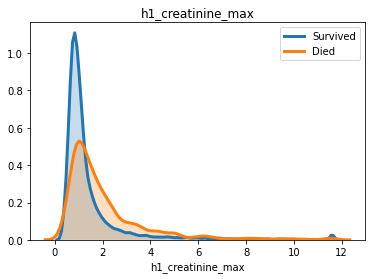

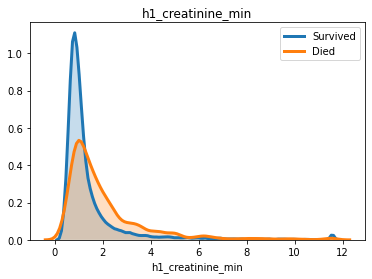

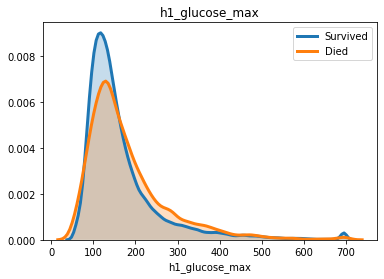

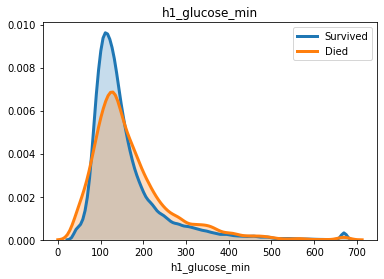

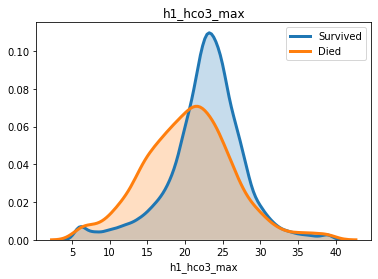

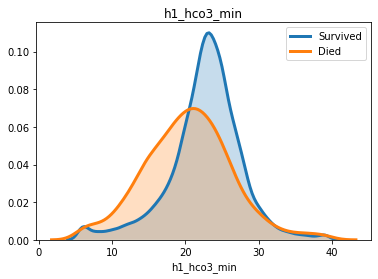

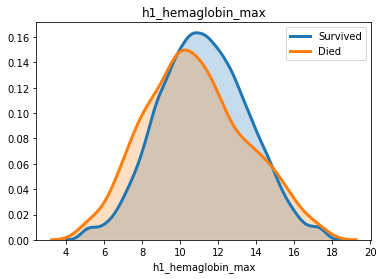

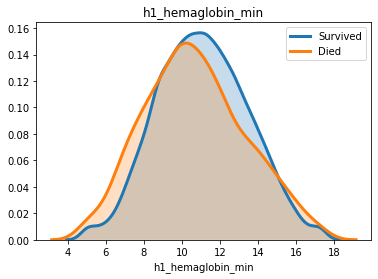

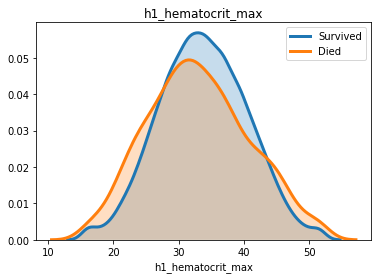

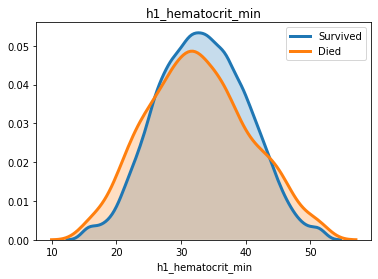

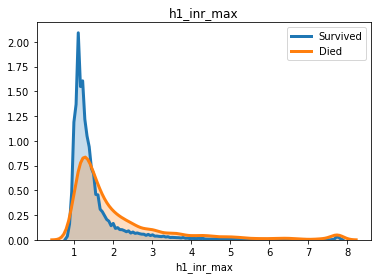

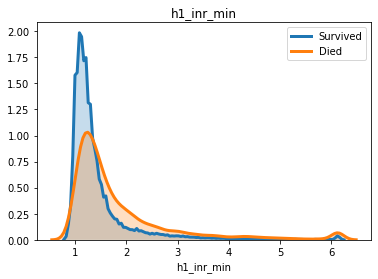

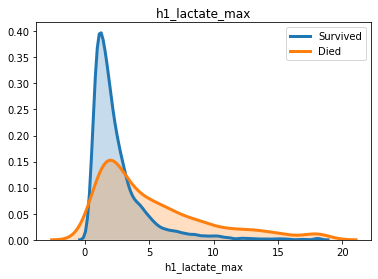

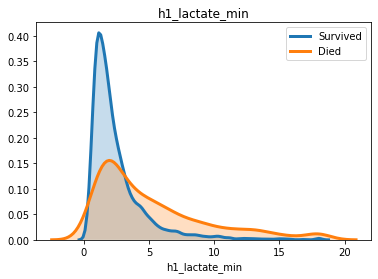

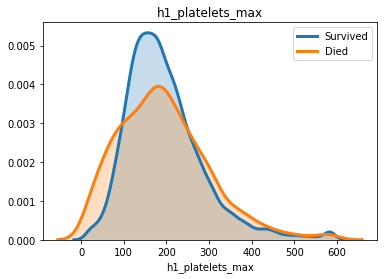

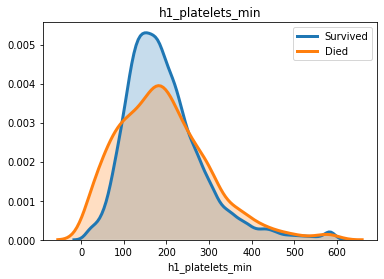

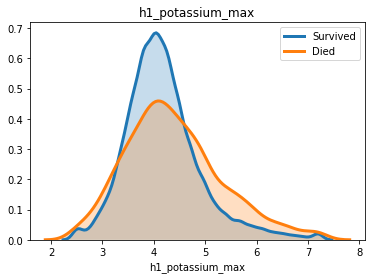

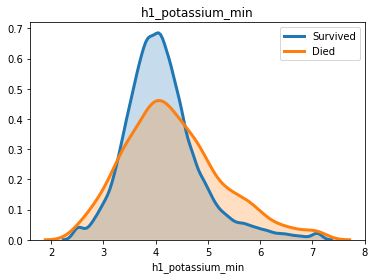

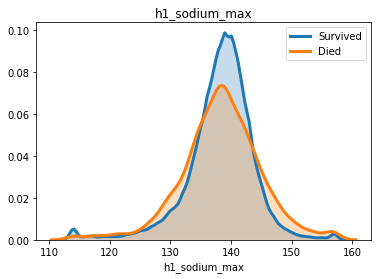

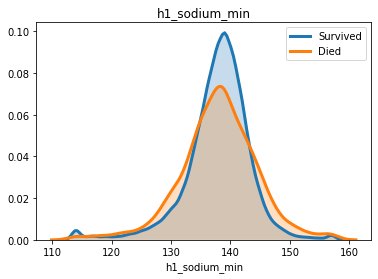

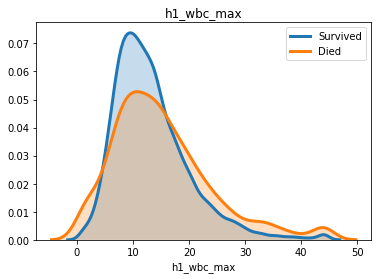

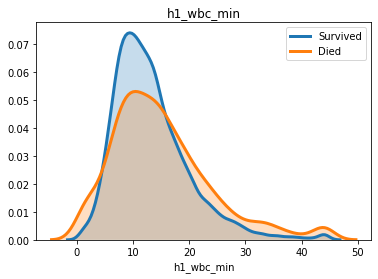

In [50]:
# Look at summary statistics for comorbidities
for i,col in enumerate(labs):
    plotKDE(str(col))

**Is this captured in the APACHE covariate?**

In [63]:
Acov

['albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'arf_apache',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'ventilated_apache',
 'wbc_apache']

In [99]:
col = df.columns[['pao2fio' in i for i in df.columns]]
df[col].head()

,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
0,NaN,NaN,NaN,NaN
1,54.8,51.000000,51.0,51.0
2,NaN,NaN,NaN,NaN
3,342.5,236.666667,337.0,337.0
4,NaN,NaN,NaN,NaN


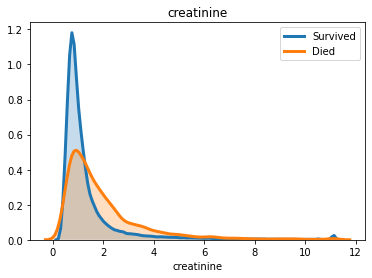

mean      1.452361
median    0.980000
Name: creatinine, dtype: float64

In [71]:
df = df.assign(creatinine = df[col].median(axis=1))
#df['albumin'] = df['albumin'].fillna(df['bun'].median(skipna =True))

plotKDE('creatinine')
df['creatinine'].agg(['mean','median'])

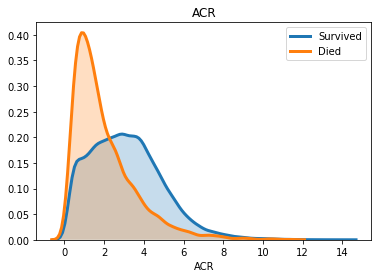

In [100]:
df = df.assign(ACR = df.albumin/df.creatinine)
plotKDE('ACR')

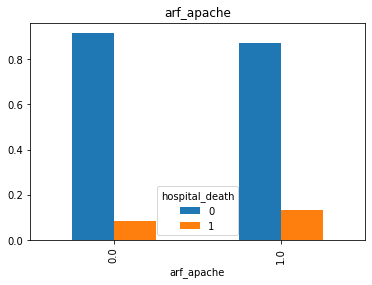

In [87]:
plotCatBar('arf_apache')

**Look at vitals**

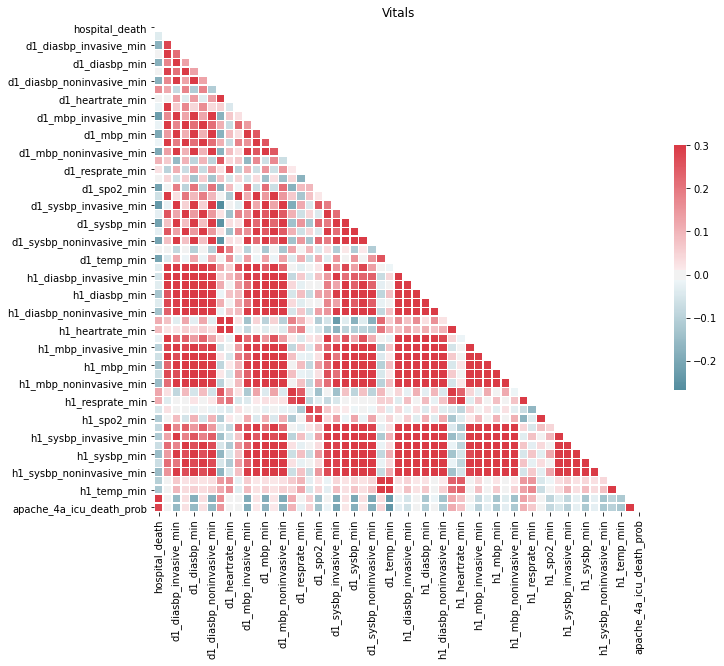

In [72]:
corr = df[['hospital_death'] + vitals + Apredict].corr(method='pearson')
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Vitals')
plt.show()

In [ ]:
vitals = corr['hospital_death']
vitals.values

In [ ]:
# Look at summary statistics for vitals
for i,col in enumerate(vitals):
    plotKDE(str(col))